In [2]:
pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12,5)
sns.set(style="whitegrid")

In [4]:
# load daily processed file (created by SARIMAX notebook)
daily = pd.read_csv("../data/daily_processed.csv", parse_dates=["Date"], index_col="Date")
daily = daily.sort_index()
daily.head()

,Local Route,Light Rail,Peak Service,Rapid Route,School,Other,total_journeys
Date,,,,,,,
2019-07-01,15987,9962,407,21223,3715,0.0,51294.0
2019-07-02,16895,10656,409,21715,3993,0.0,53668.0
2019-07-03,16613,10658,427,22025,3638,0.0,53361.0
2019-07-04,16604,10445,437,21868,3576,0.0,52930.0
2019-07-05,16040,10532,400,20697,2856,0.0,50525.0


In [5]:
# show top rows and column names to confirm what is present
print("Columns:", list(daily.columns))
print("\nHead:\n", daily.head())

Columns: ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other', 'total_journeys']

Head:
             Local Route  Light Rail  Peak Service  Rapid Route  School  Other  \
Date                                                                            
2019-07-01        15987        9962           407        21223    3715    0.0   
2019-07-02        16895       10656           409        21715    3993    0.0   
2019-07-03        16613       10658           427        22025    3638    0.0   
2019-07-04        16604       10445           437        21868    3576    0.0   
2019-07-05        16040       10532           400        20697    2856    0.0   

            total_journeys  
Date                        
2019-07-01         51294.0  
2019-07-02         53668.0  
2019-07-03         53361.0  
2019-07-04         52930.0  
2019-07-05         50525.0  


In [6]:
# show which of the expected service columns exist in the data
expected = ['Local Route','Light Rail','Peak Service','Rapid Route','School','Other']
present = [c for c in expected if c in daily.columns]
missing = [c for c in expected if c not in daily.columns]
print("Present service cols:", present)
print("Missing service cols:", missing)

Present service cols: ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']
Missing service cols: []


In [7]:
# create total_journeys by summing service columns that exist, converting to numeric safely
service_cols = [c for c in ['Local Route','Light Rail','Peak Service','Rapid Route','School','Other'] if c in daily.columns]
if 'total_journeys' not in daily.columns:
    daily[service_cols] = daily[service_cols].apply(pd.to_numeric, errors='coerce')  # ensure numeric
    daily['total_journeys'] = daily[service_cols].sum(axis=1)                        # sum available services
    print("Created total_journeys from:", service_cols)
else:
    print("total_journeys already exists")
daily[['total_journeys'] + service_cols].head()

total_journeys already exists


,total_journeys,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
Date,,,,,,,
2019-07-01,51294.0,15987,9962,407,21223,3715,0.0
2019-07-02,53668.0,16895,10656,409,21715,3993,0.0
2019-07-03,53361.0,16613,10658,427,22025,3638,0.0
2019-07-04,52930.0,16604,10445,437,21868,3576,0.0
2019-07-05,50525.0,16040,10532,400,20697,2856,0.0


In [8]:
# make sure Date is index, sorted, and save cleaned daily_processed.csv for other notebooks
if 'Date' in daily.columns:
    daily['Date'] = pd.to_datetime(daily['Date'], dayfirst=True, errors='coerce')
    daily = daily.set_index('Date')
elif not isinstance(daily.index, pd.DatetimeIndex):
    daily.index = pd.to_datetime(daily.index, dayfirst=True, errors='coerce')
daily = daily.sort_index()
daily.to_csv("../data/daily_processed.csv")
print("Saved daily_processed.csv with shape:", daily.shape)

Saved daily_processed.csv with shape: (1918, 7)


In [9]:
# quick data health: shape, null counts, date range
print("shape:", daily.shape)
print("\nnull counts:\n", daily.isnull().sum())
print("\ndate range:", daily.index.min(), "to", daily.index.max())


shape: (1918, 7)

null counts:
 Local Route       0
Light Rail        0
Peak Service      0
Rapid Route       0
School            0
Other             0
total_journeys    0
dtype: int64

date range: 2019-07-01 00:00:00 to 2024-09-29 00:00:00


In [10]:
# prepare Prophet formatted train and test (ds,y) with last 30 days as test
test_days = 30
series = daily['total_journeys']
train = series.iloc[:-test_days].reset_index().rename(columns={'Date':'ds','total_journeys':'y'})
test = series.iloc[-test_days:].reset_index().rename(columns={'Date':'ds','total_journeys':'y'})
print("Train rows:", len(train), "Test rows:", len(test))
train.head(), test.head()

Train rows: 1888 Test rows: 30


(          ds        y
 0 2019-07-01  51294.0
 1 2019-07-02  53668.0
 2 2019-07-03  53361.0
 3 2019-07-04  52930.0
 4 2019-07-05  50525.0,
           ds        y
 0 2024-08-31  19123.0
 1 2024-09-01  13328.0
 2 2024-09-02  48302.0
 3 2024-09-03  51923.0
 4 2024-09-04  51339.0)

In [11]:
# compute rolling-7 baseline aligned with test window and print MAE
rolling7 = series.rolling(7).mean()
baseline_pred = rolling7[-test_days:].values
from sklearn.metrics import mean_absolute_error
baseline_mae = mean_absolute_error(test['y'], baseline_pred)
print(f"Baseline MAE on test: {baseline_mae:.2f}")


Baseline MAE on test: 14155.21


In [12]:
# fitting a basic Prophet model (weekly seasonality on)
from prophet import Prophet

m = Prophet(
    weekly_seasonality=True,    # captures strong weekday/weekend pattern
    daily_seasonality=False,    # not needed for this dataset
    yearly_seasonality=False,   # not needed unless multi-year trend changes
    changepoint_prior_scale=0.5 # moderate trend flexibility
)

m.fit(train)  # to train on ds,y
print("Prophet model fitted.")


11:36:17 - cmdstanpy - INFO - Chain [1] start processing
11:36:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet model fitted.


In [13]:
# create future dataframe and generate forecast
future = m.make_future_dataframe(periods=30, freq='D')
forecast = m.predict(future)

# align prophet predictions with test dates
pred_prophet = forecast.set_index('ds').loc[test['ds'], 'yhat'].values

# compute metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
prophet_mae = mean_absolute_error(test['y'], pred_prophet)
prophet_rmse = np.sqrt(mean_squared_error(test['y'], pred_prophet))

print(f"Prophet MAE: {prophet_mae:.2f}")
print(f"Prophet RMSE: {prophet_rmse:.2f}")

Prophet MAE: 14273.84
Prophet RMSE: 22307.92


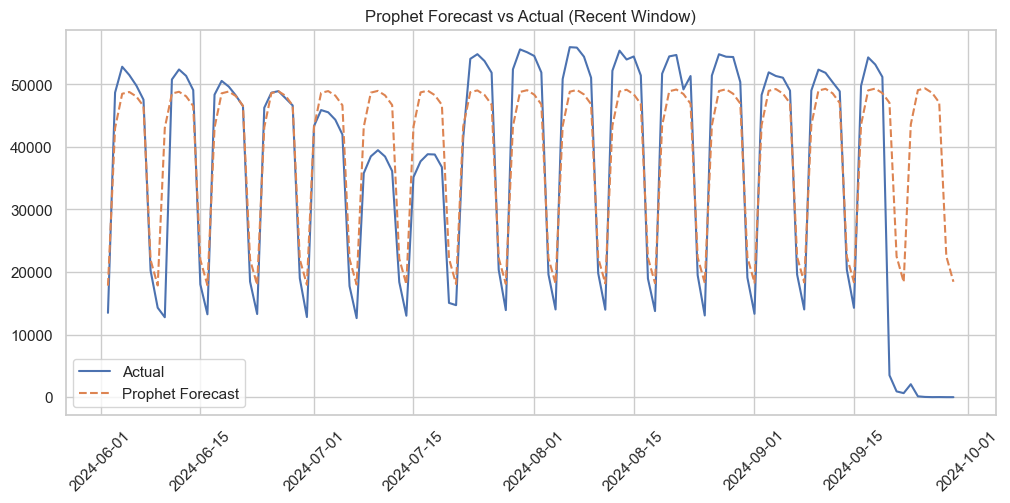

In [14]:
# plot actual vs forecast (last 120 days)
window = 120
recent_actual = daily['total_journeys'][-window:].reset_index()
recent_forecast = forecast.set_index('ds').loc[recent_actual['Date'], 'yhat'].reset_index()

plt.plot(recent_actual['Date'], recent_actual['total_journeys'], label='Actual')
plt.plot(recent_actual['Date'], recent_forecast['yhat'], label='Prophet Forecast', linestyle='--')
plt.xticks(rotation=45)
plt.title("Prophet Forecast vs Actual (Recent Window)")
plt.legend()
plt.show()


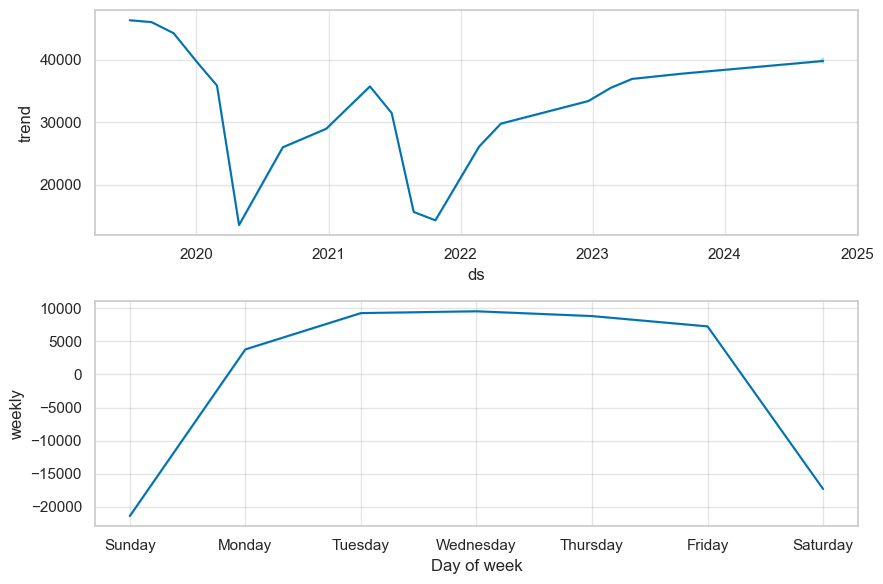

In [15]:
# plot prophet components (trend, weekly seasonality)
m.plot_components(forecast)
plt.show()

In [16]:
# add weekend regressor to train and test data
train_reg = train.copy()
test_reg = test.copy()

train_reg['is_weekend'] = pd.to_datetime(train_reg['ds']).dt.weekday.isin([5,6]).astype(int)
test_reg['is_weekend'] = pd.to_datetime(test_reg['ds']).dt.weekday.isin([5,6]).astype(int)

train_reg.head()


,ds,y,is_weekend
0,2019-07-01,51294.0,0
1,2019-07-02,53668.0,0
2,2019-07-03,53361.0,0
3,2019-07-04,52930.0,0
4,2019-07-05,50525.0,0


In [17]:
# fit prophet with weekend regressor
m2 = Prophet(
    weekly_seasonality=True,
    daily_seasonality=False,
    yearly_seasonality=False,
    changepoint_prior_scale=0.5
)

m2.add_regressor('is_weekend')  # <-- key improvement
m2.fit(train_reg)

print("Prophet with weekend regressor fitted.")


11:36:21 - cmdstanpy - INFO - Chain [1] start processing
11:36:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet with weekend regressor fitted.


In [18]:
# future dataframe and weekend regressor
future_reg = m2.make_future_dataframe(periods=30, freq='D')
future_reg['is_weekend'] = future_reg['ds'].dt.weekday.isin([5,6]).astype(int)

forecast2 = m2.predict(future_reg)

# align predictions
pred2 = forecast2.set_index('ds').loc[test_reg['ds'], 'yhat'].values

# evaluate
prophet2_mae = mean_absolute_error(test_reg['y'], pred2)
prophet2_rmse = np.sqrt(mean_squared_error(test_reg['y'], pred2))

print(f"Prophet + Weekend Reg MAE: {prophet2_mae:.2f}")
print(f"Prophet + Weekend Reg RMSE: {prophet2_rmse:.2f}")


Prophet + Weekend Reg MAE: 14277.11
Prophet + Weekend Reg RMSE: 22328.24


In [20]:
print("\nMODEL COMPARISON (MAE):")
print(f"SARIMAX: 14703.75")
print(f"Prophet Basic: {prophet_mae:.2f}")


MODEL COMPARISON (MAE):
SARIMAX: 14703.75
Prophet Basic: 14273.84


In [23]:
import joblib
joblib.dump(m2, "../models/prophet_model_joblib.pkl")   # m2 is your fitted Prophet model (e.g., m2.fit(...))
# load later
loaded_m = joblib.load("../models/prophet_model_joblib.pkl")